# Run QNet on Lander

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
import numpy as np
from tqdm.notebook import trange
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

sys.path.append('RL_lib/Agents/PPO')
sys.path.append('RL_lib/Utils')
sys.path.append('../')

import QLearn
import env_lib
from policy_ppo import Policy
from value_function import Value_function
from utils import Mapminmax,Logger,Scaler
import utils
from env_gaudet_lander import LanderEnvironment, int_to_bin, bin_to_int

In [4]:
env = LanderEnvironment(reward_type='sparse')
obs_dim = 12
act_dim = 4

policy = Policy(obs_dim,act_dim,kl_targ=0.001,epochs=20, beta=0.1, shuffle=True, servo_kl=True, discretize=True)

fname = "opt_discrete_4km"
input_normalizer = utils.load_run(policy,fname)

Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Attitude Constraint
Reward_terminal
lander env att 2 fixed

Instructions for updating:
Use keras.layers.dense instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Actions
[[0.]
 [1.]]
dict_keys(['h1/kernel:0', 'h1/bias:0', 'h2/kernel:0', 'h2/bias:0', 'h3/kernel:0', 'h3/bias:0', 'means/kernel:0', 'means/bias:0', 'logvars:0'])


## Baseline Performances

In [5]:
def ppo_policy(s):
    s_norm = input_normalizer.apply(s)
    a = policy.sample(s_norm.reshape(1,-1))
    return bin_to_int(list(a[1][0]))

def random_policy(s):
    return np.random.randint(16)

In [24]:
R_rand, s_rand = QLearn.heuristic_demo(random_policy,env,100)

In [26]:
policy.test_mode=True
R_ppo, s_ppo = QLearn.heuristic_demo(ppo_policy,env,100)

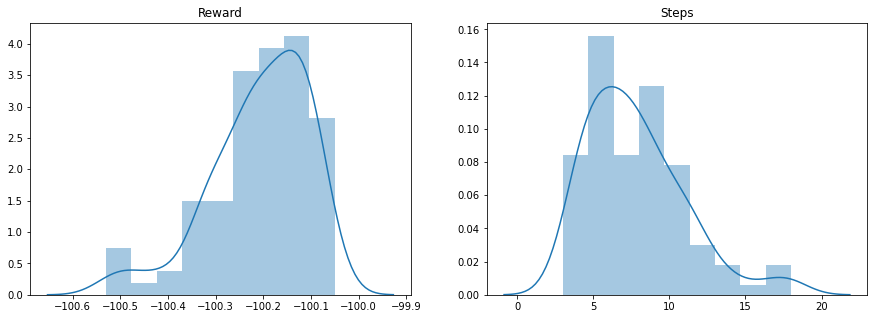

In [25]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
ax1 = sns.distplot(R_rand,ax=ax1)
_=plt.title('Reward')
ax2 = plt.subplot(122)
ax2 = sns.distplot(s_rand,ax=ax2)
_=plt.title('Steps')

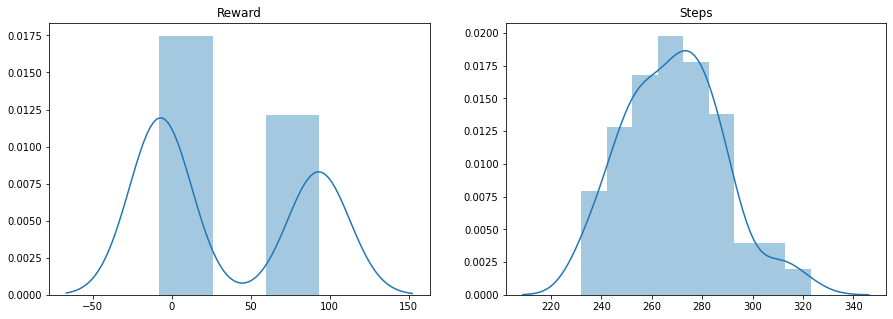

In [27]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
ax1 = sns.distplot(R_ppo,ax=ax1)
_=plt.title('Reward')
ax2 = plt.subplot(122)
ax2 = sns.distplot(s_ppo,ax=ax2)
_=plt.title('Steps')

In [6]:
policy.test_mode=True
mem_ppo = QLearn.heuristic_memory_demo(ppo_policy,env,20,fname='demo_disc_sparse.pkl')

In [8]:
dmem=pickle.load(open('demo_disc_sparse.pkl','rb'))
R_mem = [d[2] for d in dmem]
done_mem = [d[4] for d in dmem]
ind_term = np.where(done_mem)[0]
np.array(R_mem)[ind_term]

array([ 9.998e+01,  9.997e+01,  9.999e+01,  9.998e+01,  9.999e+01,
       -3.000e-02,  9.999e+01, -3.000e-02, -2.000e-02,  9.998e+01,
        9.999e+01, -3.000e-02, -3.000e-02, -3.000e-02,  9.998e+01,
        9.999e+01, -3.000e-02, -4.000e-02,  9.999e+01,  9.998e+01])

## Running Q Agent with Guidance

In [ ]:
N_ep = 2000
policy.test_mode=True
agent = QLearn.QAgent(env, net_type='QNet', f_heur=ppo_policy, n_heur=100,
                    update_steps=10, N_hid=100, eps0=0.9, gamma=0.99, n_eps=1500, memory_size=100000, minibatch_size=25)
R_ep, agent, env = do_run(agent, env, N_ep)

In [9]:
agent.nn.sess.close()

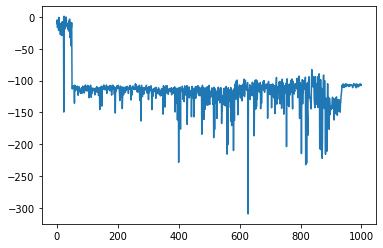

In [26]:
plt.plot(R_ep)

Using demo memory

In [19]:
del agent

In [ ]:
N_ep = 50000
dmem=pickle.load(open('demo_disc.pkl','rb'))
env = LanderEnvironment()
agent = QLearn.QAgent(env,net_type='MLPQNet',hidden_layers=[160, 80],alpha=1e-4,gamma=0.99,eps0=0.25,n_eps=40000,minibatch_size=100,memory_size=500000,demo_memory=dmem,n_demo=100)
fname = 'lander_demo_test_24_3_0.pkl'
R, steps, agent, env = QLearn.do_run(agent, env, N_ep, save_name = fname, show_progress=True)

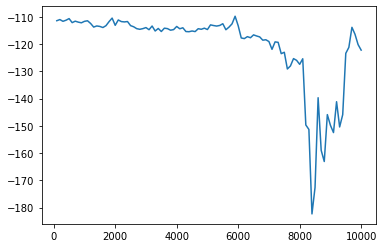

In [18]:
x,R_s=R.smooth()
plt.plot(x,R_s)

Showing example runs

In [4]:
data_all = []
for i in range(8):
    data_all.append(pickle.load(open('test_demo_21_3_{}.pkl'.format(i),'rb')))
print(['{}: {}'.format(i,np.mean(r['R'][-100:]).round(1)) for i, r in enumerate(data_all)])

['0: -138.6', '1: -161.7', '2: -133.7', '3: -123.0', '4: -140.8', '5: -122.6', '6: -193.8', '7: -121.0']


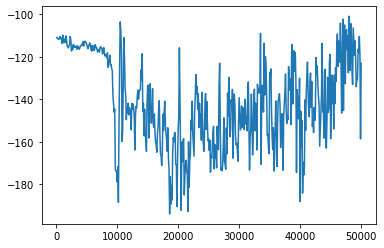

In [5]:
run_no = 3

x,R = data_all[run_no]['R'].smooth()
plt.plot(x,R)

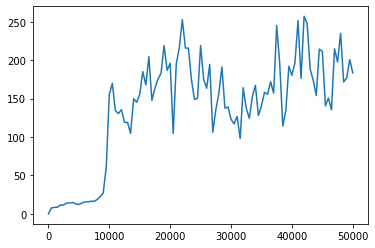

In [12]:
run_no = 3

steps = data_all[run_no]['step']
x,s_avg = QLearn.data_smooth(steps,500)
plt.plot(x,s_avg)

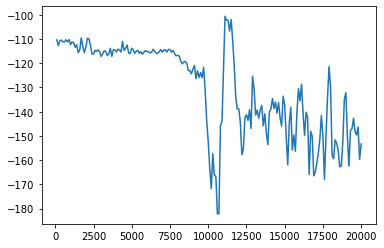

In [15]:
data_samp = pickle.load(open('lander_demo_test_20_3_mlp1.pkl','rb'))
x,R = data_samp['R'].smooth()
plt.plot(x,R)

## Using Prioritised Experience Replay

In [ ]:
N_ep = 20000
dmem=pickle.load(open('demo_disc_sparse.pkl','rb'))
env = LanderEnvironment(reward_type='sparse')
agent = QLearn.PerQAgent(env,demo_memory=dmem,net_type='MLPQNet',hidden_layers=[160, 80],alpha=1e-4,gamma=0.99,
                         eps0=0.2,n_eps=15000,minibatch_size=100,capacity=100000)
fname = 'lander_per_14_4_4.pkl'
R, steps, agent, env = QLearn.do_run(agent, env, N_ep, save_name = fname, show_progress=True)

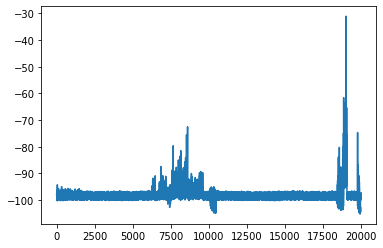

In [11]:
plt.plot(R)

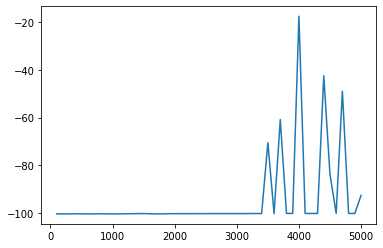

In [15]:
x,R_s=R.smooth() 
plt.plot(x,R_s)

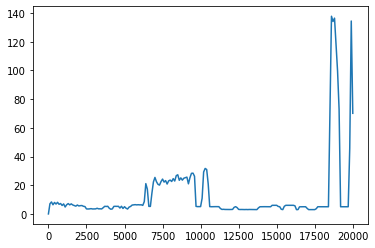

In [12]:
x,s_avg = QLearn.data_smooth(steps,100)
plt.plot(x,s_avg)

Showing old data...

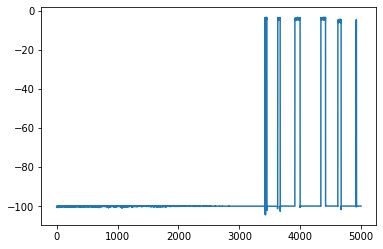

In [14]:
fname = 'lander_per_14_4_0.pkl'
data = pickle.load(open(fname,'rb'))
plt.plot(data['R'])

Testing env parameters...

In [27]:
N_ep = 20000
dmem=pickle.load(open('demo_disc_sparse.pkl','rb'))
env = LanderEnvironment(reward_type='sparse')
agent = QLearn.PerQAgent(env,demo_memory=dmem,net_type='MLPQNet',hidden_layers=[160, 80],alpha=1e-4,gamma=0.99,
                         eps0=0.1,n_eps=15000,minibatch_size=100,capacity=100000)
save_name = 'lander_env_test.pkl'

R_ep = QLearn.Reward()
steps=[]
t = trange(N_ep, desc='bar_desc', leave=True)
for ep_no in t:
    s = env.reset()
    done = False
    Rt = 0
    n_step = 0
    while not done:
        a = agent.action_select(s)
        s, r, done, _ = env.step(a)
        agent.update(s,r,done)
        Rt += r
        n_step +=1
    R_ep.append(Rt)
    steps.append(n_step)
    if ep_no>10:
        t.set_description('R: {} Step: {}'.format(np.mean(R_ep[-10:]).round(1),n_step))
        t.refresh()
    else:
        t.set_description('R: {} Step: {}'.format(np.mean(R_ep).round(1),n_step))
        t.refresh()
    data = {'params':agent.nn.get_params(),'R':R_ep,'step':steps}
    pickle.dump(data, open(save_name,'wb'))
    if Rt >-10:
        pickle.dump(env, open('env_traj.pkl','wb'))
        break

Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Attitude Constraint
Reward_terminal
lander env att 2 fixed


*** ATT VIO TYPE CNT:  [0. 0. 1.]
*** ATT VIO TYPE CNT:  [ 0. 36. 67.]
*** ATT VIO TYPE CNT:  [  0.  73. 131.]
*** ATT VIO TYPE CNT:  [  0.  87. 217.]
*** ATT VIO TYPE CNT:  [  0. 121. 283.]
*** ATT VIO TYPE CNT:  [  0. 144. 360.]
*** ATT VIO TYPE CNT:  [  0. 212. 392.]
*** ATT VIO TYPE CNT:  [  0. 226. 478.]
*** ATT VIO TYPE CNT:  [  0. 261. 544.]
*** ATT VIO TYPE CNT:  [  0. 269. 636.]
*** ATT VIO TYPE CNT:  [  0. 295. 710.]
*** ATT VIO TYPE CNT:  [  0. 295. 810.]
*** ATT VIO TYPE CNT:  [  0. 300. 905.]
*** ATT VIO TYPE CNT:  [   0.  300. 1005.]
*** ATT VIO TYPE CNT:  [   0.  300. 1105.]
*** ATT VIO TYPE CNT:  [   0.  300. 1205.]
*** ATT VIO TYPE CNT:  [   0.  300. 1305.]
*** ATT VIO TYPE CNT:  [   0.  300. 1405.]
*** ATT VIO TYPE CNT:  [   0.  301. 1504.]
*** ATT VIO TYPE CNT:  [   0.  301. 1604.]
*** ATT VIO TYPE CNT:  [   0.  350. 1655.]
*** ATT VIO TYPE CNT:  [   0.  446. 1660.]
*** ATT VIO TYPE CNT:  [   0.  543. 1663.]
*** ATT VIO TYPE CNT:  [   0.  643. 1664.]
*** ATT VIO TYPE

In [30]:
env.main_env.lander.trajectory_list[-1].keys()

dict_keys(['t', 'position', 'velocity', 'attitude', 'attitude_321', 'w', 'thrust', 'bf_thrust', 'torque', 'mass', 'fuel', 'v_ratio', 'vc', 'range', 'los', 'dlos', 'zem', 'reward', 'fuel_reward', 'tracking_reward', 'glideslope_reward', 'landing_margin', 'glideslope', 'sc_margin', 'glideslope_penalty', 'sc_penalty', 'sc_reward', 'att_penalty', 'att_reward', 'landing_reward'])